In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation((-45, 45)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), 
        transforms.ToTensor(),
        transforms.ColorJitter(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

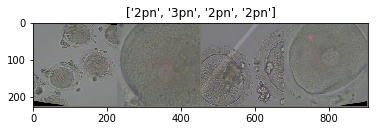

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
class_names

['1pn', '2pn', '3pn', 'gv', 'nf']

In [6]:
#https://scikit-learn.org/dev/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_labels = []
    best_preds = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_labels = []
            running_preds = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_labels.extend(list(labels.data.cpu()))
                running_preds.extend(list(preds.cpu()))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_labels = running_labels.copy()
                best_preds = running_preds.copy()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    print('Confusion matrix')
    plot_confusion_matrix(np.array(best_labels, dtype=np.int32), 
                          np.array(best_preds, dtype=np.int32), 
                          class_names, normalize=True)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names), bias=True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0007, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.5951 Acc: 0.8442
val Loss: 0.7626 Acc: 0.8798

Epoch 1/24
----------
train Loss: 0.5399 Acc: 0.8558
val Loss: 0.4207 Acc: 0.8755

Epoch 2/24
----------
train Loss: 0.5219 Acc: 0.8635
val Loss: 0.3713 Acc: 0.8798

Epoch 3/24
----------
train Loss: 0.4701 Acc: 0.8692
val Loss: 0.6209 Acc: 0.8755

Epoch 4/24
----------
train Loss: 0.4169 Acc: 0.8712
val Loss: 0.3343 Acc: 0.9142

Epoch 5/24
----------
train Loss: 0.4291 Acc: 0.8654
val Loss: 0.3347 Acc: 0.9185

Epoch 6/24
----------
train Loss: 0.3882 Acc: 0.8865
val Loss: 0.2910 Acc: 0.9142

Epoch 7/24
----------
train Loss: 0.3487 Acc: 0.8865
val Loss: 0.2758 Acc: 0.9185

Epoch 8/24
----------
train Loss: 0.3538 Acc: 0.8904
val Loss: 0.2665 Acc: 0.9142

Epoch 9/24
----------
train Loss: 0.3592 Acc: 0.8865
val Loss: 0.2654 Acc: 0.9099

Epoch 10/24
----------
train Loss: 0.3439 Acc: 0.8865
val Loss: 0.2520 Acc: 0.9185

Epoch 11/24
----------
train Loss: 0.3217 Acc: 0.8942
val Loss: 0.2466 Acc: 0.9227

Ep

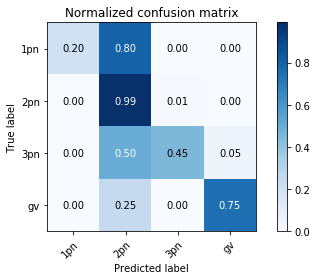

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [11]:
class_names

['1pn', '2pn', '3pn', 'gv', 'nf']

In [31]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, len(class_names), bias=True)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.0007, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.8395 Acc: 0.8192
val Loss: 1.6320 Acc: 0.8755

Epoch 1/24
----------
train Loss: 0.7963 Acc: 0.8288
val Loss: 0.6489 Acc: 0.8155

Epoch 2/24
----------
train Loss: 0.6979 Acc: 0.8058
val Loss: 0.5973 Acc: 0.8670

Epoch 3/24
----------
train Loss: 0.5807 Acc: 0.8346
val Loss: 0.4775 Acc: 0.8369

Epoch 4/24
----------
train Loss: 0.8796 Acc: 0.8365
val Loss: 0.5618 Acc: 0.8670

Epoch 5/24
----------
train Loss: 0.8201 Acc: 0.8192
val Loss: 1.1769 Acc: 0.8755

Epoch 6/24
----------
train Loss: 0.6286 Acc: 0.8577
val Loss: 0.3742 Acc: 0.8927

Epoch 7/24
----------
train Loss: 0.5306 Acc: 0.8385
val Loss: 0.3530 Acc: 0.8927

Epoch 8/24
----------
train Loss: 0.5305 Acc: 0.8538
val Loss: 0.3267 Acc: 0.9099

Epoch 9/24
----------
train Loss: 0.4854 Acc: 0.8558
val Loss: 0.3569 Acc: 0.8670

Epoch 10/24
----------
train Loss: 0.4787 Acc: 0.8538
val Loss: 0.3071 Acc: 0.8927

Epoch 11/24
----------
train Loss: 0.4332 Acc: 0.8827
val Loss: 0.2854 Acc: 0.9013

Ep

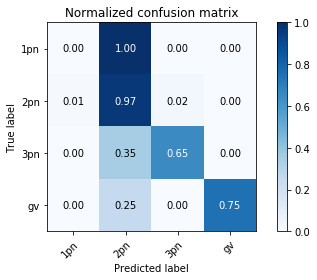

In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

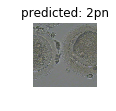

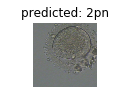

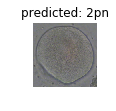

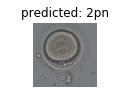

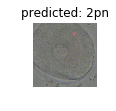

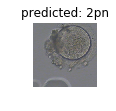

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()